In [63]:
# pip install datasets umap-learn pycddlib dask dask-expr cvxopt
from datasets import load_dataset
import os
import pandas as pd
import numpy as np
import pyarrow as pa
import pyarrow.ipc as ipc
import dask.dataframe as dd

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from scipy.spatial import ConvexHull

import polytope as pc

from pypoman import compute_polytope_vertices
from pypoman import plot_polygon, project_polytope
from pypoman import compute_polytope_halfspaces

import cdd

from umap import UMAP

import manifold

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

In [ ]:
dataset = load_dataset("calabi-yau-data/polytopes-4d", cache_dir="C:/Users/esultano/git/polytopes/data/huggingface", split="full").shuffle(seed=42)
print("Verfügbare Aufteilungen:", dataset)

In [5]:
percentage = 0.01
chunk_size = 10000
max_dfs = 3
sample_size = int(percentage * len(dataset))

dfs = []
for i in range(0, min(sample_size, max_dfs * chunk_size), chunk_size):
    chunk = dataset.select(range(i, min(i + chunk_size, sample_size)))
    dfs.append(chunk.to_pandas())

df = pd.concat(dfs, ignore_index=True)

In [6]:
df['vertex_to_point_ratio'] = df['vertex_count'] / df['point_count']
stats = df['vertex_to_point_ratio'].describe()
print(stats)

count    30000.000000
mean         0.414814
std          0.160594
min          0.035573
25%          0.294118
50%          0.404762
75%          0.523810
max          0.956522
Name: vertex_to_point_ratio, dtype: float64


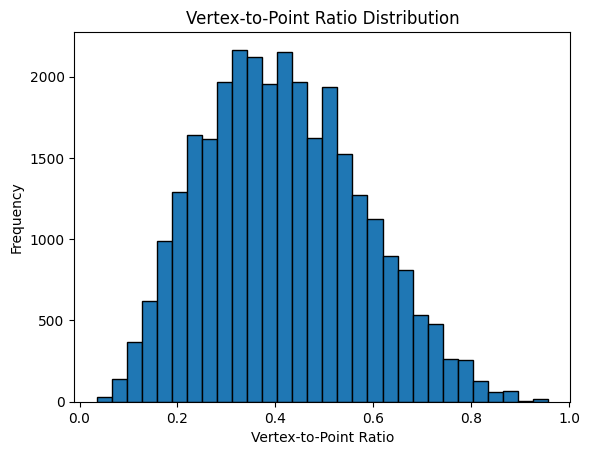

In [7]:
plt.hist(df['vertex_to_point_ratio'], bins=30, edgecolor='black')
plt.title("Vertex-to-Point Ratio Distribution")
plt.xlabel("Vertex-to-Point Ratio")
plt.ylabel("Frequency")
plt.show()

In [8]:
data = df[['vertex_count', 'point_count', 'vertex_to_point_ratio', 'h11', 'h12']]
scaler = StandardScaler()
data_normalized = scaler.fit_transform(data)

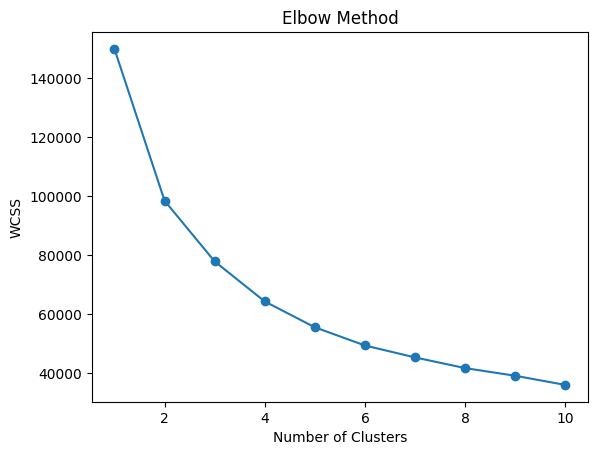

In [9]:
wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(data_normalized)
    wcss.append(kmeans.inertia_)

# Plot WCSS to find the elbow point
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

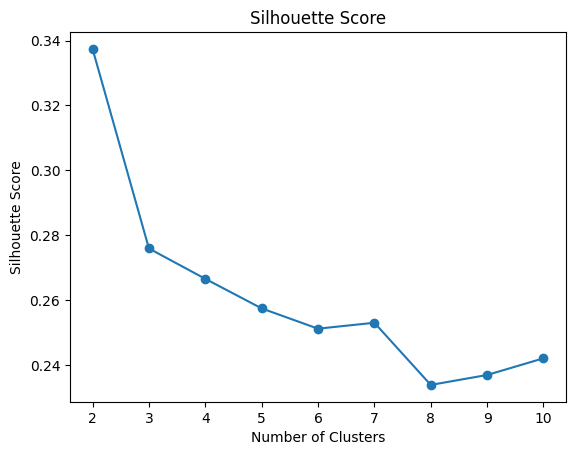

In [10]:
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(data_normalized)
    score = silhouette_score(data_normalized, kmeans.labels_)
    silhouette_scores.append(score)

plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('Silhouette Score')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

In [11]:
kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster'] = kmeans.fit_predict(data_normalized)

In [12]:
fig = px.scatter_3d(df, 
                    x='vertex_to_point_ratio', 
                    y='h11', 
                    z='h12', 
                    color='cluster',
                    title="3D Scatter Plot of Clusters in Polytopes",
                    labels={
                        'vertex_to_point_ratio': 'Vertex-to-Point Ratio',
                        'h11': 'Hodge Number h11',
                        'h12': 'Hodge Number h12'
                    })

fig.update_traces(marker=dict(size=1))

fig.write_html("3d_scatter_plot.html")

In [13]:
df['symmetry_ratio'] = df['vertex_count'] / df['dual_point_count']

In [14]:
symmetry_stats = df['symmetry_ratio'].describe()
print(symmetry_stats)

count    30000.000000
mean         0.428721
std          0.202676
min          0.030534
25%          0.280702
50%          0.395349
75%          0.540822
max          1.571429
Name: symmetry_ratio, dtype: float64


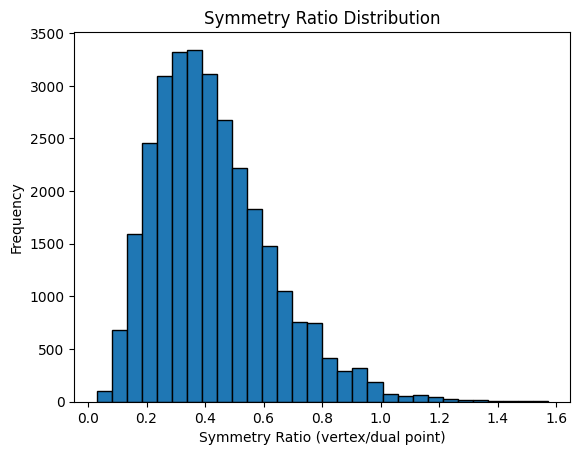

In [24]:
plt.hist(df['symmetry_ratio'], bins=30, edgecolor='black')
plt.title("Symmetry Ratio Distribution")
plt.xlabel("Symmetry Ratio (vertex/dual point)")
plt.ylabel("Frequency")
plt.show()

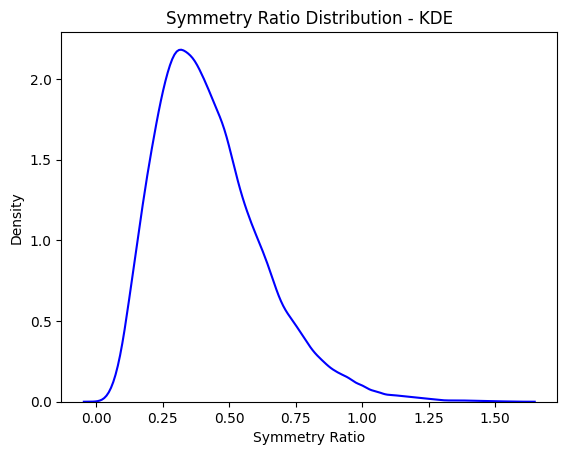

In [25]:
# Plot the KDE for 'symmetry_ratio'
sns.kdeplot(df['symmetry_ratio'], color='blue')

# Add labels and title
plt.title("Symmetry Ratio Distribution - KDE")
plt.xlabel("Symmetry Ratio")
plt.ylabel("Density")
plt.show()

C:\Users\esultano\AppData\Local\Temp\ipykernel_31300\105459467.py:7: UserWarning:

Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.



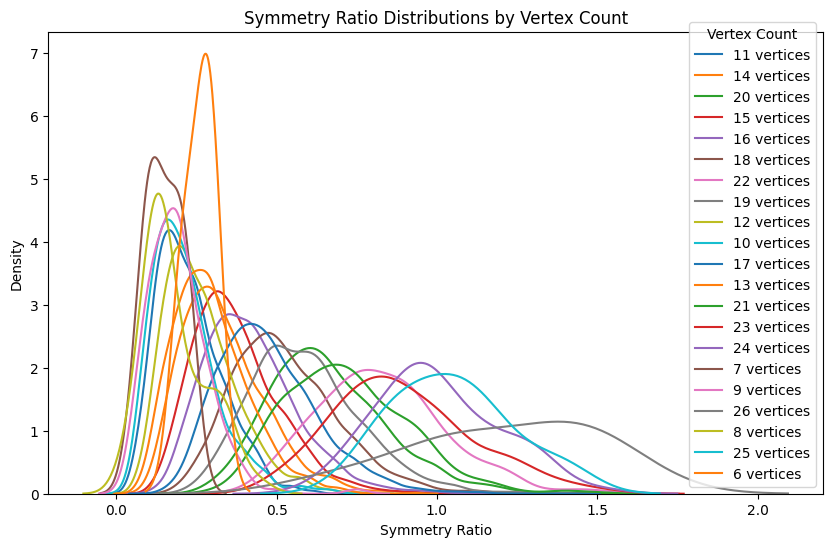

In [26]:
unique_vertex_counts = df['vertex_count'].unique()

plt.figure(figsize=(10, 6))

for count in unique_vertex_counts:
    subset = df[df['vertex_count'] == count]
    sns.kdeplot(subset['symmetry_ratio'], label=f'{count} vertices', linewidth=1.5)

plt.title("Symmetry Ratio Distributions by Vertex Count")
plt.xlabel("Symmetry Ratio")
plt.ylabel("Density")
plt.legend(title="Vertex Count")
plt.show()

In [75]:
def calculate_hull_volume(vertices):
    vertices = np.vstack(vertices)
    hull = ConvexHull(vertices)
    return hull.volume

df['volume'] = df['vertices'].apply(calculate_hull_volume)

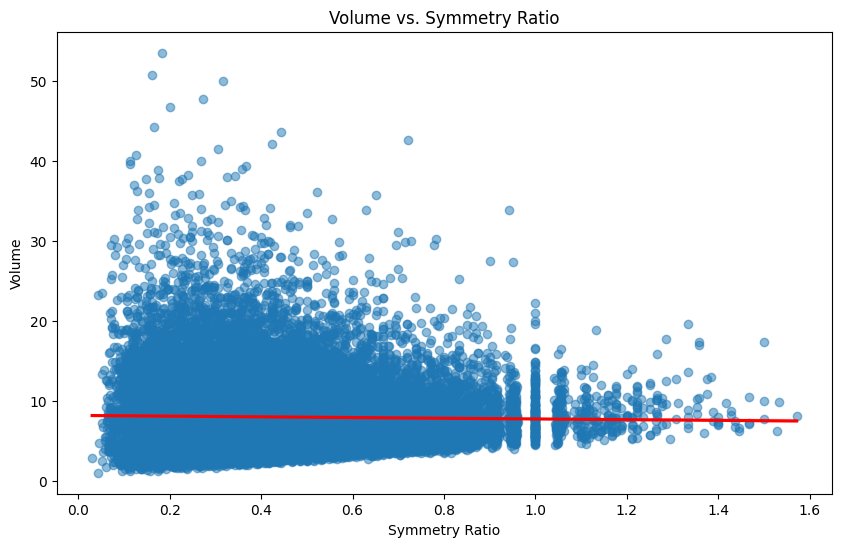

In [77]:
plt.figure(figsize=(10, 6))
sns.regplot(data=df, x='symmetry_ratio', y='volume', scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title("Volume vs. Symmetry Ratio")
plt.xlabel("Symmetry Ratio")
plt.ylabel("Volume")
plt.show()

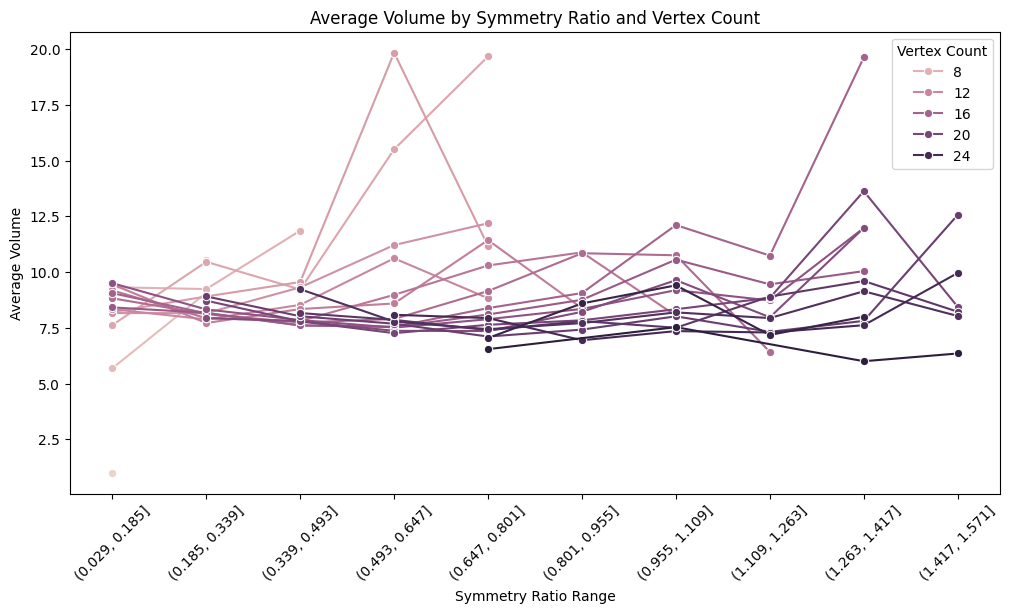

In [79]:
grouped['symmetry_range'] = grouped['symmetry_range'].astype(str)

# Plot the lineplot with updated symmetry_range format
plt.figure(figsize=(12, 6))
sns.lineplot(data=grouped, x='symmetry_range', y='volume', hue='vertex_count', marker="o")
plt.xticks(rotation=45)
plt.title("Average Volume by Symmetry Ratio and Vertex Count")
plt.xlabel("Symmetry Ratio Range")
plt.ylabel("Average Volume")
plt.legend(title="Vertex Count")
plt.show()

In [80]:
correlation = df['volume'].corr(df['symmetry_ratio'])
print(f"Correlation between Volume and Symmetry Ratio: {correlation:.2f}")

Correlation between Volume and Symmetry Ratio: -0.02


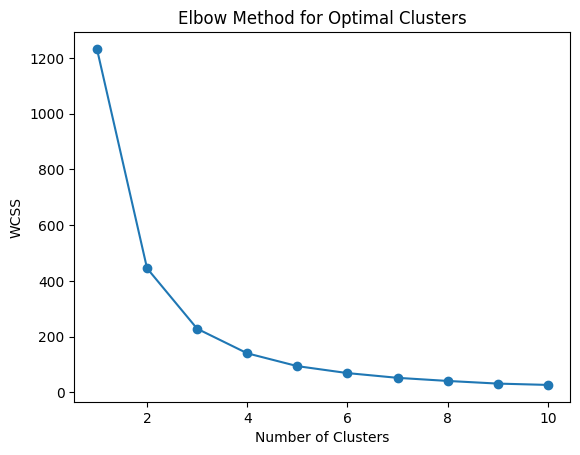

In [16]:
symmetry_data = df[['symmetry_ratio']].values

# Plot WCSS to find the elbow point
wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(symmetry_data)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

In [17]:
kmeans = KMeans(n_clusters=3, random_state=42)
df['symmetry_cluster'] = kmeans.fit_predict(symmetry_data)

In [18]:
percentile = 0.99
threshold = df['symmetry_ratio'].quantile(percentile)
df['is_outlier'] = df['symmetry_ratio'] > threshold

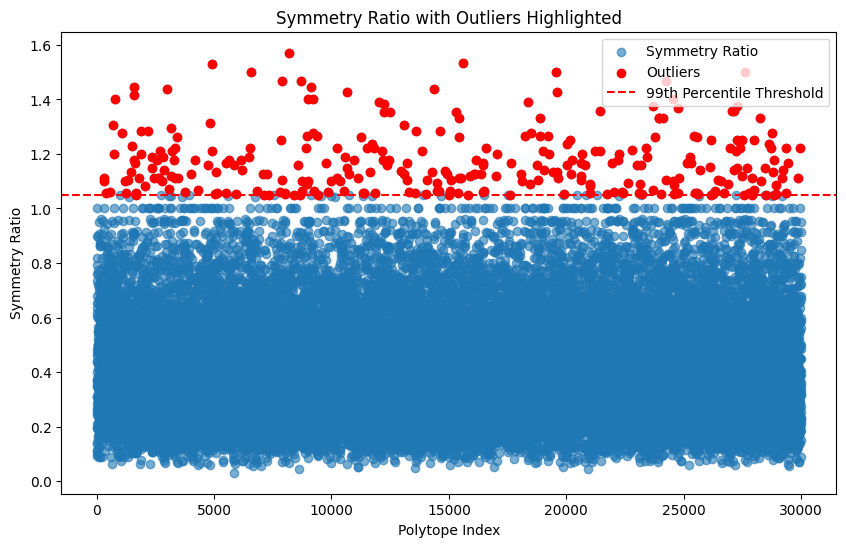

In [19]:
plt.figure(figsize=(10, 6))
plt.scatter(df.index, df['symmetry_ratio'], label="Symmetry Ratio", alpha=0.6)
plt.scatter(df[df['is_outlier']].index, df[df['is_outlier']]['symmetry_ratio'], color='red', label="Outliers")
plt.axhline(y=threshold, color='red', linestyle='--', label=f"{int(percentile * 100)}th Percentile Threshold")
plt.title("Symmetry Ratio with Outliers Highlighted")
plt.xlabel("Polytope Index")
plt.ylabel("Symmetry Ratio")
plt.legend()
plt.show()

c:\Users\esultano\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



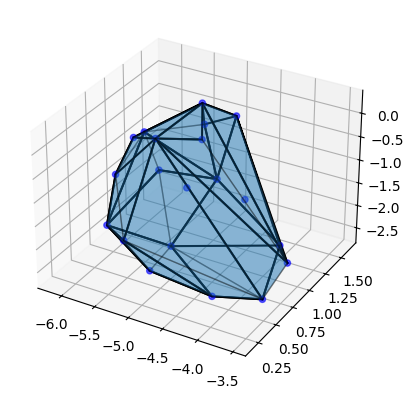

In [20]:
outliers = df[df['is_outlier']].head(5)

first_outlier = outliers.iloc[0]

vertices_4d = first_outlier['vertices']
vertices_4d = np.vstack(vertices_4d)

#pca = PCA(n_components=3)
#vertices_3d = pca.fit_transform(vertices_4d)
umap = UMAP(n_components=3, random_state=42)
vertices_3d = umap.fit_transform(vertices_4d)

hull = ConvexHull(vertices_3d)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(vertices_3d[:, 0], vertices_3d[:, 1], vertices_3d[:, 2], color='blue', alpha=0.6)

for simplex in hull.simplices:
    points = vertices_3d[simplex]
    ax.plot(points[:, 0], points[:, 1], points[:, 2], 'k-')

faces = Poly3DCollection(vertices_3d[hull.simplices], alpha=0.3, edgecolor='k')
ax.add_collection3d(faces)

plt.show()

In [21]:
# see also https://github.com/mwalczyk/polychora?tab=readme-ov-file
# https://arxiv.org/abs/2403.11141
# https://pycddlib.readthedocs.io/en/latest/examples.html#polyhedron-adjacencies-and-incidences

#vertices_4d = [[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1],[0,-2,1,2],[0,2,-1,-2],[0,0,0,-1],[0,0,-1,0],[0,-1,0,0],[1,-1,1,2],[1,-1,1,0],[0,-2,1,1],[0,-1,1,2],[0,-1,1,0],[0,0,1,1],[-1,0,-1,-1],[-1,1,0,0],[-1,2,-2,-2],[-1,-1,0,0],[-1,2,-1,-1]]

num_verts = vertices_4d.shape[0]
vertices = np.hstack((np.ones((num_verts,1)), vertices_4d))
mat = cdd.matrix_from_array(vertices, rep_type=cdd.RepType.GENERATOR)
poly = cdd.polyhedron_from_matrix(mat)

# get the adjacent vertices of each vertex
adjacencies = [list(x) for x in cdd.matrix_adjacency(mat)]
print(adjacencies)


[[9, 10, 5, 7], [9, 19, 5, 14], [5, 10, 13, 14, 16], [9, 19, 12, 7], [7, 9, 11, 12, 18], [0, 1, 2, 6, 10, 17, 19], [10, 13, 5, 15], [0, 3, 4, 8, 9, 15, 17], [10, 11, 15, 7], [0, 1, 3, 4, 7, 10, 12, 14], [0, 2, 5, 6, 8, 9, 11, 13], [4, 8, 10, 13, 18], [3, 4, 9, 14, 16], [2, 6, 10, 11, 18], [1, 2, 9, 12, 16], [6, 7, 8, 17, 18], [2, 12, 14, 18, 19], [19, 15, 5, 7], [4, 11, 13, 15, 16], [1, 3, 5, 16, 17]]


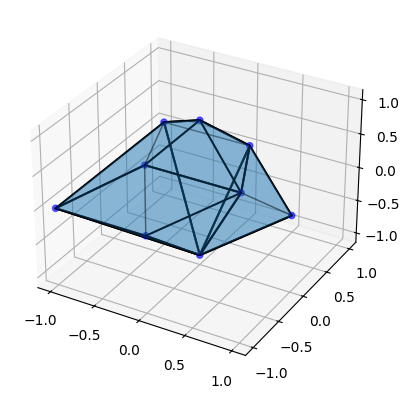

In [22]:
# Project onto 3D by setting the fourth dimension to a fixed value (e.g., w = 0)
vertices_3d = vertices_4d[vertices_4d[:, 3] == 0][:, :3]  # Slicing at w=0

hull = ConvexHull(vertices_3d)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(vertices_3d[:, 0], vertices_3d[:, 1], vertices_3d[:, 2], color='blue', alpha=0.6)

for simplex in hull.simplices:
    points = vertices_3d[simplex]
    ax.plot(points[:, 0], points[:, 1], points[:, 2], 'k-')

faces = Poly3DCollection(vertices_3d[hull.simplices], alpha=0.3, edgecolor='k')
ax.add_collection3d(faces)

plt.show()

In [64]:
V = np.array(vertices_3d)
print(V)
poly_qhull = pc.qhull(V)
print(pc.volume(poly_qhull))

[[ 1  0  0]
 [ 0  1  0]
 [ 0  0  1]
 [ 0  0 -1]
 [ 0 -1  0]
 [ 1 -1  1]
 [ 0 -1  1]
 [-1  1  0]
 [-1 -1  0]]
1.4533333333333334
